# 15. Thử nghiệm tham số TAU cho Co-Training

**Mục tiêu:**
Notebook này thực hiện thử nghiệm để tìm ra giá trị tối ưu cho tham số `TAU` (ngưỡng tin cậy) trong thuật toán Co-Training.

**Các bước thực hiện:**
1.  **Cấu hình thử nghiệm**: Định nghĩa một danh sách các giá trị `TAU` cần kiểm tra (ví dụ: từ 0.6 đến 0.95).
2.  **Chạy vòng lặp thử nghiệm**: Lặp qua từng giá trị `TAU`, chạy thuật toán Co-Training và lưu lại kết quả F1-macro trên tập test.
3.  **Áp dụng Cache**: Kết quả của mỗi lần chạy sẽ được lưu lại. Nếu một giá trị `TAU` đã được thử nghiệm trước đó, chương trình sẽ đọc lại kết quả thay vì chạy lại từ đầu.
4.  **Trực quan hóa**: Vẽ biểu đồ đường để thể hiện sự thay đổi của F1-macro theo `TAU`.
5.  **Phân tích**: Dựa vào biểu đồ để xác định khoảng giá trị `TAU` mang lại hiệu năng tốt nhất.

## Bước 1. Cấu hình thử nghiệm

In [ ]:
from pathlib import Path
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Cấu hình đường dẫn ---
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")

# --- Import các hàm từ thư viện dự án ---
from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training
)

# --- Cấu hình thử nghiệm ---
SEMI_DATASET_PATH = "data/processed/02_dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
RANDOM_STATE = 42

# Danh sách các giá trị TAU cần thử nghiệm
TAU_LIST = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Tham số cố định cho Co-Training
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20

# --- Đường dẫn lưu trữ ---
CACHE_PATH = PROJECT_ROOT / "data" / "processed" / "15_cotraining_tau_sweep_cache.json"
IMAGES_DIR = PROJECT_ROOT / "images"
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
IMAGES_DIR.mkdir(exist_ok=True)
PROCESSED_DATA_DIR.mkdir(exist_ok=True)

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard


## Bước 2. Tải dữ liệu

In [2]:
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())
print(f"Đã tải thành công dữ liệu. Số dòng: {len(df)}")

Đã tải thành công dữ liệu. Số dòng: 420768


## Bước 3. Chạy vòng lặp thử nghiệm (với Cache)

In [3]:
results = []
cached_results = {}

# Tải cache nếu tồn tại
if CACHE_PATH.exists():
    print(f"Đang tải cache từ: {CACHE_PATH}")
    with open(CACHE_PATH, 'r', encoding='utf-8') as f:
        cached_results = json.load(f)

for tau in TAU_LIST:
    print(f"\n--- Đang xử lý với TAU = {tau} ---")
    tau_key = str(tau) # Khóa trong file JSON phải là string

    if tau_key in cached_results:
        print(f"✅ Đã tìm thấy kết quả cho TAU = {tau} trong cache. Đang tải...")
        f1_macro = cached_results[tau_key]
    else:
        print(f"Không có cache. Chạy thuật toán Co-Training...")
        # Cấu hình cho lần chạy này
        data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=RANDOM_STATE)
        ct_cfg = CoTrainingConfig(
            tau=tau,
            max_iter=MAX_ITER,
            max_new_per_iter=MAX_NEW_PER_ITER,
            min_new_per_iter=MIN_NEW_PER_ITER,
            val_frac=VAL_FRAC,
        )
        
        # Chạy thuật toán
        out = run_co_training(df, data_cfg, ct_cfg)
        f1_macro = out['test_metrics']['f1_macro']
        
        # Lưu kết quả vào cache
        cached_results[tau_key] = f1_macro
        print(f"   -> F1-macro đạt được: {f1_macro:.4f}. Đang lưu vào cache...")

    results.append({
        "tau": tau,
        "f1_macro": f1_macro
    })

# Cập nhật lại file cache với các kết quả mới
print("\n💾 Cập nhật file cache...")
with open(CACHE_PATH, 'w', encoding='utf-8') as f:
    json.dump(cached_results, f, ensure_ascii=False, indent=2)

print("🎉 Hoàn thành tất cả các thử nghiệm!")

# Chuyển đổi kết quả sang DataFrame
df_results = pd.DataFrame(results)


--- Đang xử lý với TAU = 0.6 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4074. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.65 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4081. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.7 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4087. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.75 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4160. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.8 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4096. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.85 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4161. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.9 ---
Không có cache. Chạy thuật toán Co-Training...
   -> F1-macro đạt được: 0.4044. Đang lưu vào cache...

--- Đang xử lý với TAU = 0.95 ---
Không có c

## Bước 4. Trực quan hóa kết quả

Biểu đồ đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\15_cotraining_tau_sweep.png
Dữ liệu kết quả đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\15_cotraining_tau_sweep.csv


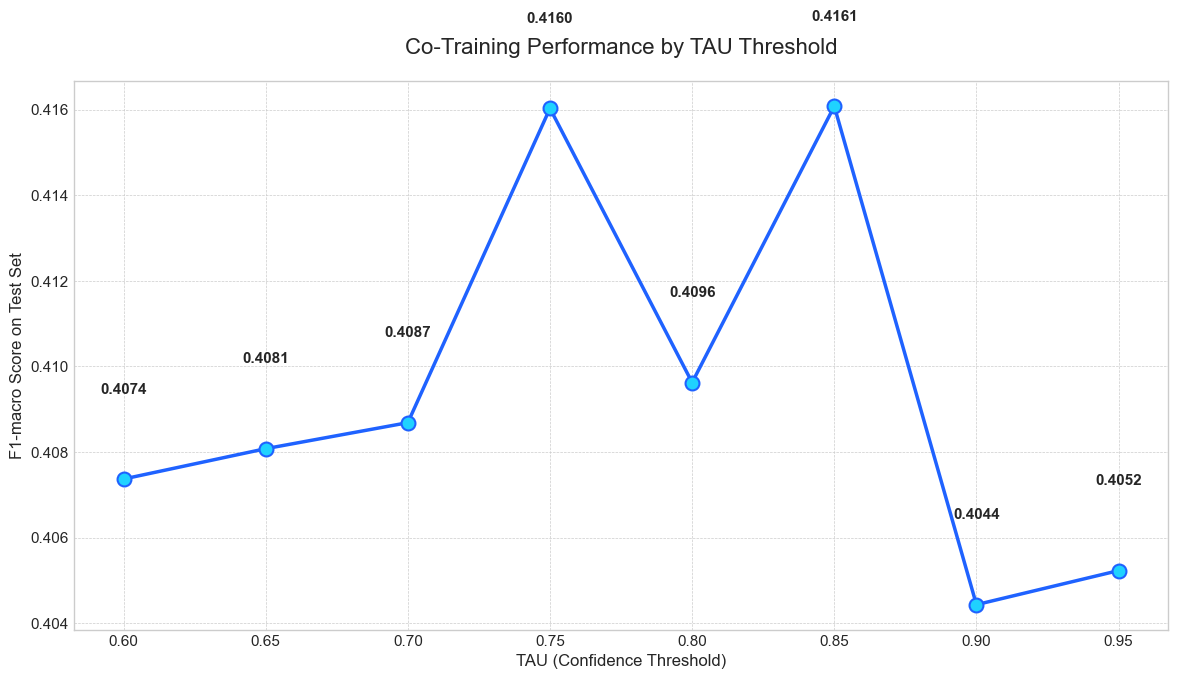

In [4]:
if not df_results.empty:
    # --- Cài đặt cho biểu đồ ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # --- Vẽ biểu đồ đường ---
    ax.plot(
        df_results['tau'], 
        df_results['f1_macro'], 
        marker='o', 
        linestyle='-',
        color='#1F62FF', # Tông màu xanh nước biển
        markersize=10,
        linewidth=2.5,
        markerfacecolor='#1FD2FF',
        markeredgewidth=1.5,
        markeredgecolor='#1F62FF'
    )

    # --- Thêm giá trị tại mỗi điểm ---
    for i, row in df_results.iterrows():
        ax.text(row['tau'], row['f1_macro'] + 0.002, f"{row['f1_macro']:.4f}", 
                ha='center', fontsize=11, fontfamily='Arial', fontweight='bold')

    # --- Định dạng theo quy tắc (tiếng Anh) ---
    ax.set_title('Co-Training Performance by TAU Threshold', fontsize=16, fontfamily='Arial', pad=20)
    ax.set_xlabel('TAU (Confidence Threshold)', fontsize=12, fontfamily='Arial')
    ax.set_ylabel('F1-macro Score on Test Set', fontsize=12, fontfamily='Arial')
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Thêm padding
    plt.tight_layout(pad=1.5) 

    # --- Lưu kết quả ---
    # Lưu biểu đồ
    fig_path = IMAGES_DIR / "15_cotraining_tau_sweep.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Biểu đồ đã được lưu tại: {fig_path}")

    # Lưu DataFrame
    csv_path = PROCESSED_DATA_DIR / "15_cotraining_tau_sweep.csv"
    df_results.to_csv(csv_path, index=False)
    print(f"Dữ liệu kết quả đã được lưu tại: {csv_path}")

    plt.show()
else:
    print("Không có kết quả để vẽ biểu đồ.")